# Data-Driven Domain of Shapes

**Input to define domain**:

- Dataset of 2D shapes (cross sections) with consistent landmarks both in number and reparametrization---i.e., each discrete shape is represented by the same number of landmarks generated by a consistent CST-cosine reparametrization over the shape

- Dependencies detailed below

In [1]:
# Python
import os
import numpy as np
# G2Aero
from g2aero.PGA import PGAspace, Dataset
from g2aero import SPD
from g2aero import Grassmann as gr
#Plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read airfoil data from subdirectory
We begin by loading a saved data set of consistently reparametrized discrete airfoil shapes stored in one of the .npz files in `data/airfoils/`. These specific airfoils correspond to tens of thousands of perturbations to CST expansions used in wind turbine blade design with variations in the trailing edge (TE) gap size.

In [2]:
# this is where we've stored our airfoil data
shapes_folder  = os.path.join(os.getcwd(), '../../data/airfoils/', )
# this is a nice set of randomly generated CST shapes for wind turbine design provided by Andrew Glaws
shapes = np.load(os.path.join(shapes_folder, 'CST_shapes_TE_gap.npz'))['shapes']
print("Dataset:")
print(f"Shape of data = {shapes.shape}")
print(f"N_shapes = {shapes.shape[0]}")
print(f"n_landmarks in every shape = {shapes.shape[1]}")

Dataset:
Shape of data = (13000, 401, 2)
N_shapes = 13000
n_landmarks in every shape = 401


## Build PGA space and get coordinates
Next, we build the PGA space from the data set of airfoil shapes. The `PGAspace.create_from_dataset()` method returns a `pga` object and an array of normal coordinates `T` spanning a subspace at the tangent space of the Karcher mean defining a section through the Grassmannian.

In [3]:
# compute Karcher mean and run PGA to define coordinates
pga, T = PGAspace.create_from_dataset(shapes)
# do the same over the SPD manifold to represent rescalings
_, P, b = pga.shapes2PGA(shapes)
P0 = SPD.Karcher(P)
L3, S3, ell = SPD.PGA(P0,P)

Karcher mean convergence:
||V||_F = 0.10235806971182138
||V||_F = 0.0001552688989775973
||V||_F = 2.711475818136911e-07
||V||_F = 5.985411637820536e-10
Karcher mean convergence:
||V||_F = 0.40098078989714303
||V||_F = 6.627185577609348e-05
||V||_F = 2.746545832747702e-07
||V||_F = 1.9677970483452856e-09


Next, we visualize the decay in eigenvalues of the sample covariance of normal coordinates to infer a maximum dimensionality of the submanifold.

Text(0, 0.5, 'eigenvalue')

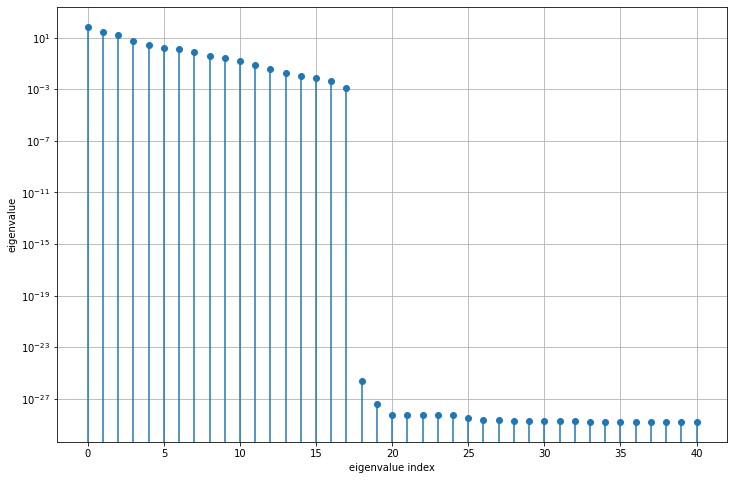

In [4]:
# visualize the decay in the first 40 Grassmann eigenvalues (SPD is three dimensional)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.stem(pga.S[:41]**2)
plt.yscale('log')
plt.grid(True, which='both')
plt.xlabel('eigenvalue index')
plt.ylabel('eigenvalue')

Evidently, this space is only 18 dimensional. This happens to be consistent with the dimension of the CST expansions used to generate the data. (according to the researchers responsible for carefully currating this database of wind turbine shapes) Now that we have computed the necessary approximation of intrinsic statistical moments, basis for the tangent space, and normal coordinates let's save them so we don't have to repeat these computations.

In [5]:
# save the computed Grassmannian PGA space
pga.save_to_file(filename=os.path.join(shapes_folder,'../pga_space/', 'CST_Gr_PGA.npz'))
# also save the SPD PGA space
np.savez(os.path.join(shapes_folder,'../pga_space/', 'CST_SPD_PGA.npz'), \
            data=P, karcher_mean=P0, basis=L3, coords=ell, weights=S3)

To visualize this PGA space, we plot the first four out of `2*(n_landmarks - 2)` ordered normal coordinates over the Grassmannian as scatterplots and histograms representing marginal slices through the data.

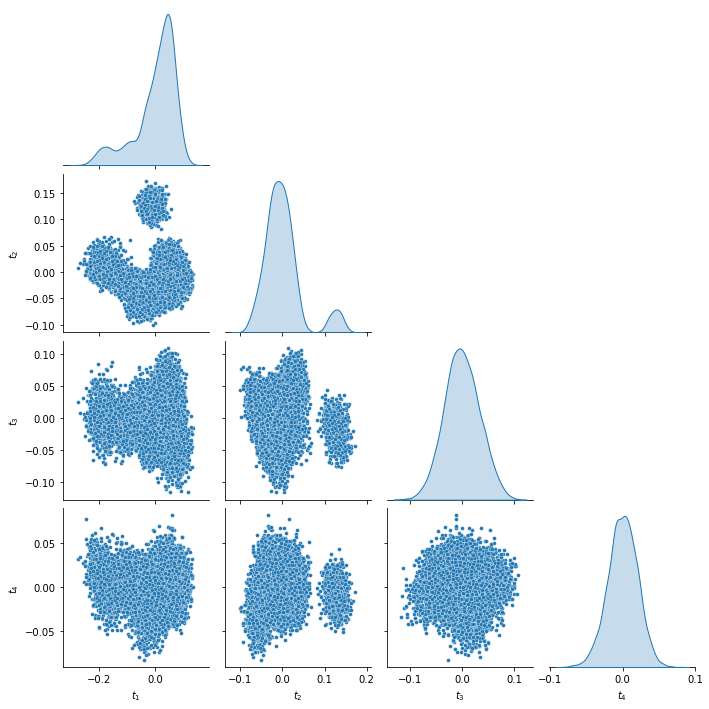

In [6]:
coord_names = ['$t_1$', '$t_2$', '$t_3$', '$t_4$']
df_all = pd.DataFrame(data=T[:, :4], columns=coord_names)
sns_plot = sns.pairplot(df_all, x_vars=coord_names, y_vars=coord_names,
                        diag_kind='kde', corner=True, plot_kws=dict(s=15))

## Low-dimensional shape reconstruction
Let's try reconstructing a shape using fewer normal coordinates (low-dimensional PGA space) and compare it to the original shape. Here we set the reduced number of parameters (the dimension of PGA space) to `r=4` and choose the shape with index `j=1` for demonstration. We also need to calculate LA standardization. LA standardized shapes and corresponding affine transformation is stored in the `data` object of `Dataset` class.

In [7]:
# assign r as the dimension of the PGA shape
r = 4 # should always be less than or equal to 2*(n_landmarks - 2)
# pick a shape based on index from the dataset
j = 1 # should be less than or equal to N_shapes-1
# save LA standardized shapes and corresponding affine transformation
data = Dataset(shapes)

First, we demonstrate that this is a distinct element of the Grassmannian. Using the Grassmannian distance (square root of the sum of squared principal anlges between representative shape elements), we emphasize that we are moving along a different (reduced dimension) section of the Grassmannian given a non-zero Grassmannian distance.

In [8]:
# transform from PGA space to element on Grassmann
shape_gr_new = pga.PGA2gr_shape(T[j,:r], original_shape_gr=data.shapes_gr[j])
# compute Grassmannian distance error
err_gr = gr.distance(shape_gr_new, data.shapes_gr[j])
print(f'Grassmannian distance: {err_gr}')

Grassmannian distance: 0.03607142623673442


Then, we compute a worst-case Euclidean error (maximum over Euclidean distances between row-wise pairs of shape landmarks) to offer a human interpretable notion of error in the reconstructed image of the shape in the plane. This reconstruction utilizes a consistent right inverse with nominal `M[j]` and `b[j]` defined by the LA standardization of the original shape.

In [9]:
def norm_inf2(sh1, sh2):
    d = np.max(np.linalg.norm(sh1-sh2, ord=2, axis=1))
    return d

# transform from PGA space to physical scales
phys_shape = pga.PGA2shape(T[j,:r], M=data.M[j], b=data.b[j], 
                           original_shape_gr=data.shapes_gr[j])
# compute worst-case Euclidean error in row-wise landmarks
err_inf2 = norm_inf2(phys_shape, shapes[j])
print(f'Worst-case Euclidean error: {err_inf2}')

Worst-case Euclidean error: 0.004075096848162013


With only four dimensions, the error in the reconstruction of this particular example shape is quite small. Finally, we overlay the low-dimensional shape with the original shape to visualze the magnitude of the mis-match over physically relevant scales.

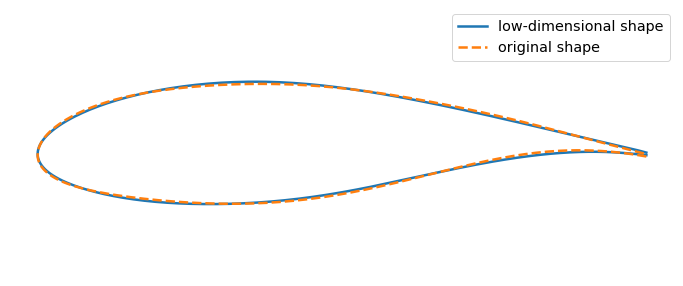

In [10]:
# plot the low-dimensional shape and the original shape
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.plot(phys_shape[:,0], phys_shape[:,1],linewidth=2.5, label='low-dimensional shape')
plt.plot(shapes[j,:,0], shapes[j,:,1],'--',linewidth=2.5, label='original shape')
# formatting
plt.axis('off')
ax.axis('equal')
ax.legend(fontsize='x-large')